In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf, hour, mean, month, year, to_date
from pyspark.sql.window import Window
from tqdm.notebook import tqdm

In [2]:
!pip install tqdm

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [5]:
spark

# Schema de données

In [6]:
schema = StructType() \
    .add("STATION", IntegerType(), False) \
    .add("DATE", TimestampType(), False) \
    .add("SOURCE", IntegerType(), True) \
    .add("LATITUDE", FloatType(), True) \
    .add("LONGITUDE", FloatType(), True) \
    .add("ELEVATION", StringType(), True) \
    .add("NAME", StringType(), True) \
    .add("REPORT_TYPE", StringType(), True) \
    .add("CALL_SIGN", StringType(), True) \
    .add("QUALITY_CONTROL", StringType(), True) \
    .add("WND", StringType(), True) \
    .add("CIG", StringType(), True) \
    .add("VIS", StringType(), True) \
    .add("TMP", StringType(), True) \
    .add("DEW", StringType(), True) \
    .add("SLP", StringType(), True) \
    .add("GA1", StringType(), True) \
    .add("GA2", StringType(), True) \
    .add("GA3", StringType(), True) \
    .add("GA4", StringType(), True) \
    .add("GF1", StringType(), True) \
    .add("MA1", StringType(), True) \
    .add("MW1", StringType(), True) \
    .add("MW2", StringType(), True) \
    .add("MW3", StringType(), True) \
    .add("OC1", StringType(), True) \
    .add("REM", StringType(), True) \
    .add("EQD", StringType(), True)

# Chargement des données

In [7]:
# station_2018 = spark.read.load("./data/2018", format="csv", header=True, schema=schema, inferSchema=False)
# station_2018.show()

In [8]:
cols_of_interest = ("STATION","DATE","SOURCE","LATITUDE","LONGITUDE","ELEVATION","NAME","REPORT_TYPE","CALL_SIGN","QUALITY_CONTROL","WND","CIG","VIS","TMP","DEW","SLP")

all_stations = spark.read.load("./data/*", format="csv", header=True, schema=schema, inferSchema=False).select(*cols_of_interest)

In [9]:
all_stations

STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP
826099999,2008-01-01 00:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"280,1,N,0062,1","22000,1,9,N","024140,1,N,1","+0020,1","-0040,1","10170,1"
826099999,2008-01-01 00:53:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KCCR,V020,"100,1,N,0021,1","22000,1,9,N","016093,1,N,1","+9999,9","-0030,1","10231,1"
826099999,2008-01-01 00:53:00,4,0.0,0.0,0.0,WXPOD8270,FM-16,KDAL,V020,"360,1,N,0057,1","22000,1,9,N","016093,1,N,1","+9999,9","+9999,9","99999,9"
826099999,2008-01-01 01:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0046,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10181,1"
826099999,2008-01-01 01:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"300,1,N,0067,1","22000,1,9,N","016093,1,N,1","+0030,1","-0040,1","99999,9"
826099999,2008-01-01 01:53:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KCCR,V020,"100,1,N,0031,1","22000,1,9,N","016093,1,N,1","+9999,9","-0030,1","10229,1"
826099999,2008-01-01 02:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0051,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10192,1"
826099999,2008-01-01 02:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"280,1,N,0041,1","22000,1,9,N","016093,1,N,1","+0020,1","-0040,1","10190,1"
826099999,2008-01-01 02:53:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KCCR,V020,"080,1,N,0041,1","22000,1,9,N","016093,1,N,1","+9999,9","-0030,1","10231,1"
826099999,2008-01-01 03:00:00,4,0.0,0.0,0.0,WXPOD8270,SY-MT,KFMH,V020,"300,1,N,0041,1","22000,1,9,N","016000,1,N,1","+0017,1","-0044,1","10203,1"


In [10]:
# Nombre de lignes
all_stations.count()

9573561

## Supprimer les lignes du champ TMP avec des valeurs vides OU des +9999

In [11]:
all_stations = all_stations.na.drop(how="any", subset=["TMP"]).filter(~all_stations.TMP.contains("+9999"))

## Supprimer les lignes du champ ELEVATION avec des valeurs vides OU des +9999

In [12]:
all_stations = all_stations.na.drop(how="any", subset=["ELEVATION"]).filter(~all_stations.ELEVATION.contains("+9999"))

## Supprimer les lignes du champ DEW avec des valeurs vides OU des +9999

In [13]:
all_stations = all_stations.na.drop(how="any", subset=["DEW"]).filter(~all_stations.DEW.contains("+9999"))

In [14]:
# Nombre de lignes après le drop
all_stations.count()

9097319

In [15]:
# Le schema de données
all_stations.printSchema()

root
 |-- STATION: integer (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- SOURCE: integer (nullable = true)
 |-- LATITUDE: float (nullable = true)
 |-- LONGITUDE: float (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- DEW: string (nullable = true)
 |-- SLP: string (nullable = true)



## Split de la colonne température

In [16]:
@udf(returnType=FloatType())
def extract_tmp(tmp_col: str):
    return int(tmp_col.split(',')[0].lstrip('+')) / 10

all_stations = all_stations.withColumn('temperature', extract_tmp(all_stations['TMP']))

## Split de la colonne DEW

In [17]:
@udf(returnType=FloatType())
def extract_dew(dew_col: str):
    return int(dew_col.split(',')[0].lstrip('+')) / 10

all_stations = all_stations.withColumn('precipitation', extract_dew(all_stations['DEW']))

In [18]:
all_stations.printSchema()

root
 |-- STATION: integer (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- SOURCE: integer (nullable = true)
 |-- LATITUDE: float (nullable = true)
 |-- LONGITUDE: float (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- DEW: string (nullable = true)
 |-- SLP: string (nullable = true)
 |-- temperature: float (nullable = true)
 |-- precipitation: float (nullable = true)



## Création du champ season

In [19]:
@udf(returnType=StringType())
def create_season(month: int):
    if month in [7, 8, 9]:
        season = 'Summer'
    elif month in [10, 11, 12]:
        season = 'Autumn'
    elif month in [1, 2, 3]:
        season = 'Winter'
    else:
        season = 'Spring'
    return season

all_stations = all_stations.withColumn('season', create_season(month("DATE")))

In [20]:
all_stations.printSchema()

root
 |-- STATION: integer (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- SOURCE: integer (nullable = true)
 |-- LATITUDE: float (nullable = true)
 |-- LONGITUDE: float (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- DEW: string (nullable = true)
 |-- SLP: string (nullable = true)
 |-- temperature: float (nullable = true)
 |-- precipitation: float (nullable = true)
 |-- season: string (nullable = true)



In [21]:
all_stations

STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP,temperature,precipitation,season
826099999,2008-01-01 00:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"280,1,N,0062,1","22000,1,9,N","024140,1,N,1","+0020,1","-0040,1","10170,1",2.0,-4.0,Winter
826099999,2008-01-01 01:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0046,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10181,1",1.0,-4.0,Winter
826099999,2008-01-01 01:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"300,1,N,0067,1","22000,1,9,N","016093,1,N,1","+0030,1","-0040,1","99999,9",3.0,-4.0,Winter
826099999,2008-01-01 02:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"270,1,N,0051,1","22000,1,9,N","024140,1,N,1","+0010,1","-0040,1","10192,1",1.0,-4.0,Winter
826099999,2008-01-01 02:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"280,1,N,0041,1","22000,1,9,N","016093,1,N,1","+0020,1","-0040,1","10190,1",2.0,-4.0,Winter
826099999,2008-01-01 03:00:00,4,0.0,0.0,0.0,WXPOD8270,SY-MT,KFMH,V020,"300,1,N,0041,1","22000,1,9,N","016000,1,N,1","+0017,1","-0044,1","10203,1",1.7,-4.4,Winter
826099999,2008-01-01 03:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"280,1,N,0041,1","22000,1,9,N","016093,1,N,1","+0010,1","-0030,1","10200,1",1.0,-3.0,Winter
826099999,2008-01-01 04:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"999,9,V,0010,1","22000,1,9,N","024140,1,N,1","-0030,1","-0050,1","10196,1",-3.0,-5.0,Winter
826099999,2008-01-01 04:53:00,4,0.0,0.0,0.0,WXPOD8270,AUTO,KCGI,V020,"260,1,N,0036,1","22000,1,9,N","016093,1,N,1","+0000,1","-0030,1","10207,1",0.0,-3.0,Winter
826099999,2008-01-01 05:00:00,4,0.0,0.0,0.0,WXPOD8270,FM-15,KFMH,V020,"210,1,N,0015,1","22000,1,9,N","024140,1,N,1","-0040,1","-0050,1","10199,1",-4.0,-5.0,Winter


## Moyenne des températures par année/mois/journée/saison

In [22]:
# Par année
mean_tmp_by_year = all_stations.groupBy([year("DATE").alias("year")]).agg(mean("temperature").alias("mean_tmp"))
# mean_tmp_by_year = mean_tmp_by_year.sort("year")
mean_tmp_by_year

year,mean_tmp
2018,2.02892985837642
2006,4.198319969806843
2014,2.6191008699119065
2004,5.131428905904472
2012,2.642136988047152
2016,2.6419137324431894
2000,6.675598381763011
2010,2.2187558525408133
2008,3.5118217018204954
2002,4.9676523198771125


In [23]:
# Par mois
mean_tmp_by_month = all_stations.groupBy([year("DATE").alias("year"), month("DATE").alias("month")]).agg(mean("temperature").alias("mean_tmp"))
mean_tmp_by_month = mean_tmp_by_month.sort("year", "month")
mean_tmp_by_month

year,month,mean_tmp
2000,1,0.3074673309805384
2000,2,0.36254681658216736
2000,3,1.596641281798461
2000,4,4.482280090297883
2000,5,9.460334322288798
2000,6,11.581003816287653
2000,7,13.813049385753972
2000,8,13.543284406689663
2000,9,10.82036165711583
2000,10,8.544176122778072


In [24]:
# Par jour
mean_tmp_by_day = all_stations.groupBy(to_date("DATE").cast("date").alias("date")).agg(mean("temperature").alias("mean_tmp"), mean("precipitation").alias("mean_dew"))
mean_tmp_by_day = mean_tmp_by_day.sort("date")
mean_tmp_by_day

date,mean_tmp,mean_dew
2000-01-01,-0.6913435528855989,-2.661609555304897
2000-01-02,1.6868237187302406,-0.4137352778436681
2000-01-03,1.8514730731921183,-0.81927190840015
2000-01-04,1.483537588544491,-1.1463874158779446
2000-01-05,0.9789781888679079,-1.2681542806212995
2000-01-06,2.552817631606613,-0.2935121658965589
2000-01-07,3.8882087838468453,1.28043559999102
2000-01-08,3.839368419491931,0.8844421055332611
2000-01-09,2.260709533338206,-0.4636141918417884
2000-01-10,1.9078086605776257,-0.34842125259904694


In [25]:
# Par saison
mean_tmp_by_season = all_stations.groupBy([year("DATE").alias("year"), "season"]).agg(mean("temperature").alias("mean_tmp"))
mean_tmp_by_season = mean_tmp_by_season.sort("year", "season")
mean_tmp_by_season

year,season,mean_tmp
2000,Autumn,4.720289722700962
2000,Spring,8.537327611599503
2000,Summer,12.729399040020416
2000,Winter,0.7629455038457351
2002,Autumn,-2.250965532512785
2002,Spring,9.633681104914784
2002,Summer,14.437111945727972
2002,Winter,-2.177031213023564
2004,Autumn,1.6442266303804682
2004,Spring,8.237668406676073


In [26]:
# Avec SQL
# all_stations.createOrReplaceTempView("stations_view")
# spark.sql('''SELECT STATION, year(DATE), month(DATE), month, AVG(temperature)
# FROM stations_view
# GROUP BY year(DATE), month(DATE)''').show()

## Min/Max des températures par année/mois/journée/saison

In [27]:
# Par année
min_max_tmp_by_year = all_stations.groupBy([year("DATE").alias("year")]).agg(F.min("temperature").alias("min_tmp"), F.max("temperature").alias("max_tmp"))
min_max_tmp_by_year = min_max_tmp_by_year.sort("year")
min_max_tmp_by_year

year,min_tmp,max_tmp
2000,-36.4,39.0
2002,-42.0,54.0
2004,-38.6,31.2
2006,-41.3,41.0
2008,-37.2,35.0
2010,-42.0,36.0
2012,-39.4,42.0
2014,-41.7,37.4
2016,-42.4,38.0
2018,-37.8,33.0


In [28]:
# Par mois
min_max_tmp_by_month = all_stations.groupBy([year("DATE").alias("year"), month("DATE").alias("month")]).agg(F.min("temperature").alias("min_tmp"), F.max("temperature").alias("max_tmp"))
min_max_tmp_by_month = min_max_tmp_by_month.sort("year", "month")
min_max_tmp_by_month

year,month,min_tmp,max_tmp
2000,1,-36.4,18.6
2000,2,-31.6,20.5
2000,3,-33.2,30.0
2000,4,-27.6,28.1
2000,5,-13.5,34.2
2000,6,-30.0,32.0
2000,7,-1.6,31.0
2000,8,-2.6,39.0
2000,9,-6.0,26.0
2000,10,-19.7,21.6


In [29]:
# Par jour
min_max_tmp_by_day = all_stations.groupBy(to_date("DATE").cast("date").alias("date")).agg(F.min("temperature").alias("min_tmp"), F.max("temperature").alias("max_tmp"))
min_max_tmp_by_day = min_max_tmp_by_day.sort("date")
min_max_tmp_by_day

date,min_tmp,max_tmp
2000-01-01,-24.1,10.3
2000-01-02,-19.1,11.6
2000-01-03,-21.0,11.9
2000-01-04,-14.7,9.2
2000-01-05,-25.5,11.5
2000-01-06,-25.0,11.7
2000-01-07,-17.0,12.0
2000-01-08,-5.6,10.0
2000-01-09,-11.0,8.4
2000-01-10,-17.1,18.0


In [30]:
# Par saison
min_max_tmp_by_season = all_stations.groupBy([year("DATE").alias("year"), "season"]).agg(F.min("temperature").alias("min_tmp"), F.max("temperature").alias("max_tmp"))
min_max_tmp_by_season = min_max_tmp_by_season.sort("year", "season")
min_max_tmp_by_season

year,season,min_tmp,max_tmp
2000,Autumn,-35.9,21.6
2000,Spring,-30.0,34.2
2000,Summer,-6.0,39.0
2000,Winter,-36.4,30.0
2002,Autumn,-40.2,26.9
2002,Spring,-26.5,40.0
2002,Summer,-10.0,35.5
2002,Winter,-42.0,54.0
2004,Autumn,-34.3,26.5
2004,Spring,-24.3,27.0


In [31]:
type(mean_tmp_by_day)

pyspark.sql.dataframe.DataFrame

## Moyenne des Températures et des Elevations (niveau de la mer) par année et par station

In [32]:
mean_tmp_elevation_by_year = all_stations.groupBy([year("DATE").alias("year"), "STATION"]).agg(mean("temperature").alias("mean_tmp"), mean("ELEVATION").alias("mean_elevation"))
mean_tmp_elevation_by_year = mean_tmp_elevation_by_year.sort("year")
mean_tmp_elevation_by_year

year,STATION,mean_tmp,mean_elevation
2000,1052099999,2.795407672212292,81.0
2000,1047099999,-0.2626838228726924,307.0
2000,2104099999,0.7085956425148215,485.0
2000,1282099999,6.599833437434937,14.0
2000,1380099999,2.1158102720681384,930.0
2000,1274099999,5.990419589186256,242.0
2000,1007099999,-4.319181947098002,7.700000000000407
2000,1049099999,3.4205753341466143,2.7400000000005087
2000,1304099999,8.538272481974152,25.0
2000,1199099999,-1.1789363093095446,382.0


In [33]:
df_pandas = mean_tmp_elevation_by_year.toPandas()

In [34]:
df_pandas.head()

,year,STATION,mean_tmp,mean_elevation
0,2000,2.036100e+09,-0.641496,468.00
1,2000,1.062100e+09,-3.057015,10.00
2,2000,1.446100e+09,3.712513,714.00
3,2000,1.103100e+09,-3.337736,47.00
4,2000,1.008100e+09,-3.928514,26.82


In [35]:
import seaborn as sns
%matplotlib inline

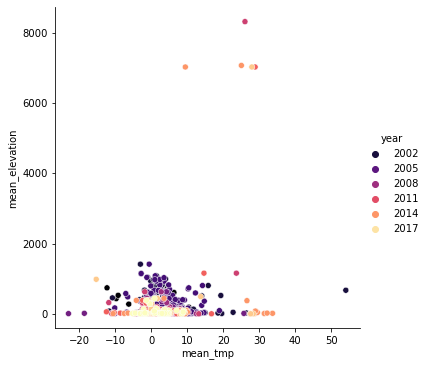

In [33]:
g = sns.relplot(x="mean_tmp", y="mean_elevation", hue="year", data=df_pandas, palette ='magma')


## Moyenne des précipitations par année/mois/journée/saison

In [36]:
# Par année
mean_dew_by_year = all_stations.groupBy([year("DATE").alias("year")]).agg(mean("precipitation").alias("mean_dew"))
mean_dew_by_year = mean_dew_by_year.sort("year")
mean_dew_by_year

year,mean_dew
2000,3.3976029699797183
2002,1.1699431880681324
2004,1.3705745875269004
2006,0.06400380370757716
2008,-0.5769365603211875
2010,-1.5306842123999715
2012,-1.0557326189705005
2014,-1.1412107132447464
2016,-0.9859972284280087
2018,-1.544628024069679


In [37]:
# Par mois
mean_dew_by_month = all_stations.groupBy([year("DATE").alias("year"), month("DATE").alias("month")]).agg(mean("precipitation").alias("mean_dew"))
mean_dew_by_month = mean_dew_by_month.sort("year", "month")
mean_dew_by_month

year,month,mean_dew
2000,1,-2.22585739342567
2000,2,-2.223443110113843
2000,3,-2.1909402819660304
2000,4,0.7374987902612976
2000,5,4.288623330527115
2000,6,7.0469047289418825
2000,7,10.124199817993109
2000,8,10.294106408377466
2000,9,7.471645181153495
2000,10,5.971984277996696


In [38]:
# Par jour
mean_dew_by_day = all_stations.groupBy(to_date("DATE").cast("date").alias("date")).agg(mean("precipitation").alias("mean_dew"))
mean_dew_by_day = mean_dew_by_day.sort("date")
mean_dew_by_day

date,mean_dew
2000-01-01,-2.661609555304897
2000-01-02,-0.4137352778436681
2000-01-03,-0.81927190840015
2000-01-04,-1.1463874158779446
2000-01-05,-1.2681542806212995
2000-01-06,-0.2935121658965589
2000-01-07,1.28043559999102
2000-01-08,0.8844421055332611
2000-01-09,-0.4636141918417884
2000-01-10,-0.34842125259904694


In [39]:
# Par saison
mean_dew_by_season = all_stations.groupBy([year("DATE").alias("year"), "season"]).agg(mean("precipitation").alias("mean_dew"))
mean_dew_by_season = mean_dew_by_season.sort("year", "season")
mean_dew_by_season

year,season,mean_dew
2000,Autumn,2.4943389161915266
2000,Spring,4.044186724388636
2000,Summer,9.301643358178655
2000,Winter,-2.2132236443830866
2002,Autumn,-4.850687951480845
2002,Spring,3.9325055437478187
2002,Summer,9.950273595478293
2002,Winter,-4.869713861757881
2004,Autumn,-0.8682852488262387
2004,Spring,2.667493256095658


## Moyenne des Températures et des précipitations par année et par mois

In [40]:
mean_dew_elevation_by_year = all_stations.groupBy([year("DATE").alias("year"), month("DATE").alias("month")]).agg(mean("temperature").alias("mean_tmp"), mean("precipitation").alias("mean_dew"))
mean_dew_elevation_by_year = mean_dew_elevation_by_year.sort("year", "month")
mean_dew_elevation_by_year

year,month,mean_tmp,mean_dew
2000,1,0.3074673309805384,-2.22585739342567
2000,2,0.36254681658216736,-2.223443110113843
2000,3,1.596641281798461,-2.1909402819660304
2000,4,4.482280090297883,0.7374987902612976
2000,5,9.460334322288798,4.288623330527115
2000,6,11.581003816287653,7.0469047289418825
2000,7,13.813049385753972,10.124199817993109
2000,8,13.543284406689663,10.294106408377466
2000,9,10.82036165711583,7.471645181153495
2000,10,8.544176122778072,5.971984277996696


In [41]:
from functools import reduce

In [42]:
from tqdm.notebook import tqdm
def add(num):
    return reduce(lambda x,y: x+y, tqdm(range(num+1))) if type(num) == int else 0

In [43]:
add(50000000)

  0%|          | 0/50000001 [00:00<?, ?it/s]

1250000025000000

In [119]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Load training data
training = mean_tmp_by_day

vectorAssembler = VectorAssembler(inputCols = ["mean_tmp"], outputCol = 'features')
v_training = vectorAssembler.transform(training)
v_training = v_training.select(['features', 'mean_dew'])
v_training.show(3)




+--------------------+-------------------+
|            features|           mean_dew|
+--------------------+-------------------+
|[-0.6913435528855...| -2.661609555304897|
|[1.6868237187302406]|-0.4137352778436681|
|[1.8514730731921183]|  -0.81927190840015|
+--------------------+-------------------+
only showing top 3 rows



In [120]:
splits = v_training.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [122]:
lr = LinearRegression(featuresCol = 'features', labelCol='mean_dew', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train_df)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: [0.9045439527710389]
Intercept: -3.4061386621643788


In [123]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.216172
r2: 0.964447


In [124]:
train_df.describe().show()

+-------+--------------------+
|summary|            mean_dew|
+-------+--------------------+
|  count|                2567|
|   mean|-0.10872256165914682|
| stddev|  6.4512504170886045|
|    min|  -16.80887826686047|
|    max|   15.18383820859167|
+-------+--------------------+



In [129]:
lr_predictions = lrModel.transform(test_df)
lr_predictions.select("prediction","mean_dew","features").show()

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="mean_dew",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-------------------+--------------------+--------------------+
|         prediction|            mean_dew|            features|
+-------------------+--------------------+--------------------+
| -4.207978309503249| -3.8617127996859177|[-0.8864573632740...|
| -4.031489292214292|  -2.661609555304897|[-0.6913435528855...|
|-3.5106608730013695| -1.9647778211912474|[-0.1155523847313...|
|-3.3602311151515654| -1.5069484246072804|[0.05075214628562...|
|-2.8755611486725927| -3.1141628524467473|[0.5865690792209494]|
|-2.0642137077379297| -1.1463874158779446| [1.483537588544491]|
| -1.680441875194672|-0.34842125259904694|[1.9078086605776257]|
|-0.8720994797138317|   1.033914135929946|[2.8014550035823094]|
|0.11091708037552062|    1.28043559999102|[3.8882087838468453]|
| -8.231699517942934|  -7.792093793258402|[-5.334799752953538]|
| -7.157243801826258|  -6.061637010656005|[-4.146957290655141]|
| -6.790238085997596|   -7.29052670257767|[-3.741221654808643]|
|-3.4953397740848215| -2.777489960678370

In [128]:
test_result = lrModel.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 1.22827


## Choses à faire


0) Faire valider le 1er modele par Sayf
1) Arrondir toutes les valeurs
2) Refaire le split (train/test)
3) D'autres algos : bataille d'I.A.
4) Voir d'autres prédictions prtinentes à faire